Hill slopes for Pareto data (n=10000):
    1    0.010000      100         0.88
    2    0.010000      100         1.78
    3    0.010000      100         2.88
    4    0.010000      100         4.20
Hill slopes for Pareto data (n=100000):
    1    0.001000      100         0.91
    1    0.010000     1000         1.05
    2    0.001000      100         2.03
    2    0.010000     1000         1.89
    3    0.001000      100         2.48
    3    0.010000     1000         2.93
    4    0.001000      100         4.65
    4    0.010000     1000         3.95
Hill slopes for Pareto data (n=1000000):
    1    0.000100      100         1.07
    1    0.001000     1000         1.01
    1    0.010000    10000         1.00
    2    0.000100      100         1.93
    2    0.001000     1000         2.07
    2    0.010000    10000         2.05
    3    0.000100      100         2.56
    3    0.001000     1000         3.07
    3    0.010000    10000         3.00
    4    0.000100      100         3.80


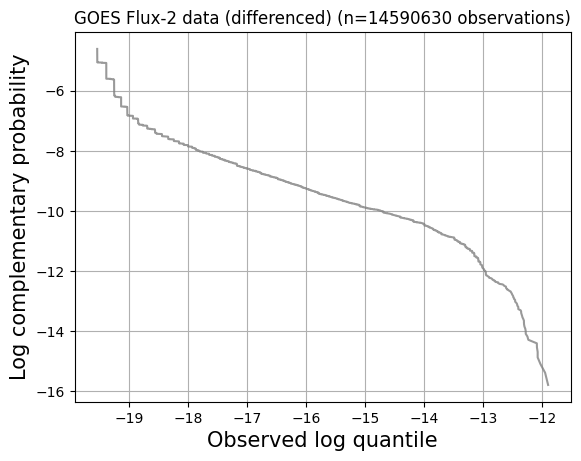

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats
from read import get_goes

df = get_goes(2017)

# Estimate the tail index.  If P(X > t) ~ 1/x^a, then
# the Hill estimator estimates a.
def hill(x, p=0.001):
    x = np.sort(x)
    n = len(x)
    k = int(p*n)
    m = n - k
    lx = np.log(x[m:])
    lx -= lx[0]
    alpha = 1 / np.mean(lx)
    return alpha

# Make a Pareto plot using the upper p proportion
# of the data in x.

def pareto_plot(x, title, p=0.01):

    # Probability points corresponding to the upper
    # p fraction of the data.
    n = len(x[0])
    k = int((1 - p) * n)
    q = np.arange(1, n+1) / (n+2)
    q = q[k:]

    plt.clf()
    plt.title("%s (n=%d observations)" % (title, len(x[0])))
    plt.grid(True)
    for y in x:
        y = np.sort(y)
        y = y[k:]
        plt.plot(np.log(y), np.log(1 - q), color="grey", alpha=0.8)
    plt.xlabel("Observed log quantile", size=15)
    plt.ylabel("Log complementary probability", size=15)
    pdf.savefig()

pdf = PdfPages("tail_py.pdf")

# Check the Hill estimator using Pareto data
for n in [int(1e4), int(1e5), int(1e6)]:
    print("Hill slopes for Pareto data (n=%d):" % n)
    for b in [1, 2, 3, 4]:
        pareto_plot([stats.pareto.rvs(b, size=n) for _ in range(10)], "Pareto data with b=%.1f" % b)

        # Equivalent: f1 = np.exp(-np.log(np.random.uniform(size=n)) / b)
        f1 = stats.pareto.rvs(b, size=n)
        for p in [1e-5, 1e-4, 1e-3, 1e-2]:
            if p*n > 10:
                alpha = hill(f1, p)
                print("%5d    %8.6f %8d %12.2f" % (b, p, int(p*len(f1)), alpha))

# Check the Hill estimator using non-Pareto data with a Pareto tail
n = int(1e6)
print("\nHill slopes for non-Pareto data with Pareto tail (n=%d):" % n)
for b in [1, 2, 3, 4]:
    x = []
    for _ in range(10):
        f1 = stats.pareto.rvs(b, size=n)
        ii = np.random.choice(range(n), n//2)
        f1[ii] = -np.log(np.random.uniform(len(ii)))
        x.append(f1)
    pareto_plot(x, "Pareto/exponential mixture with b=%.1f" % b)
    f1 = x[0]
    for p in [1e-5, 1e-4, 1e-3, 1e-2]:
        alpha = hill(f1, p)
        print("%5d    %8.6f %8d %12.2f" % (b, p, int(p*len(f1)), alpha))

# What does the Hill estimator do when the tail is not heavy?
n = int(1e6)
x = [np.random.normal(size=n) for _ in range(10)]
pareto_plot(x, "Gaussian data")
f1 = x[0]
print("\nGaussian (light-tailed) data:")
for p in [1e-5, 1e-4, 1e-3, 1e-2]:
    alpha = hill(f1, p)
    print("%8.6f %8d %12.2f" % (p, int(p*len(f1)), alpha))

# Make Pareto plots of the GOES-flux data and first differences.
pareto_plot([df["Flux1"].values], "GOES Flux-1 data")
pareto_plot([df["Flux2"].values], "GOES Flux-2 data")
pareto_plot([np.diff(df["Flux1"].values)], "GOES Flux-1 data (differenced)")
pareto_plot([np.diff(df["Flux2"].values)], "GOES Flux-2 data (differenced)")

# Estimate tail parameters for the GOES-flux data and first differences.
for d in [False, True]:
    f1 = df["Flux1"].values
    if d:
        print("\nX-ray flux data (differenced):")
        f1 = np.diff(f1)
    else:
        print("\nX-ray flux data:")
    for p in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]:
        alpha = hill(f1, p)
        print("%8.6f %8d %12.2f" % (p, int(p*len(f1)), alpha))

pdf.close()